ROC AUC: 0.9899
Chosen Point -> TPR: 0.80, FPR: 0.01449
Real World Impact -> True Positives: 80, False Positives: 14494
Precision: 0.0001


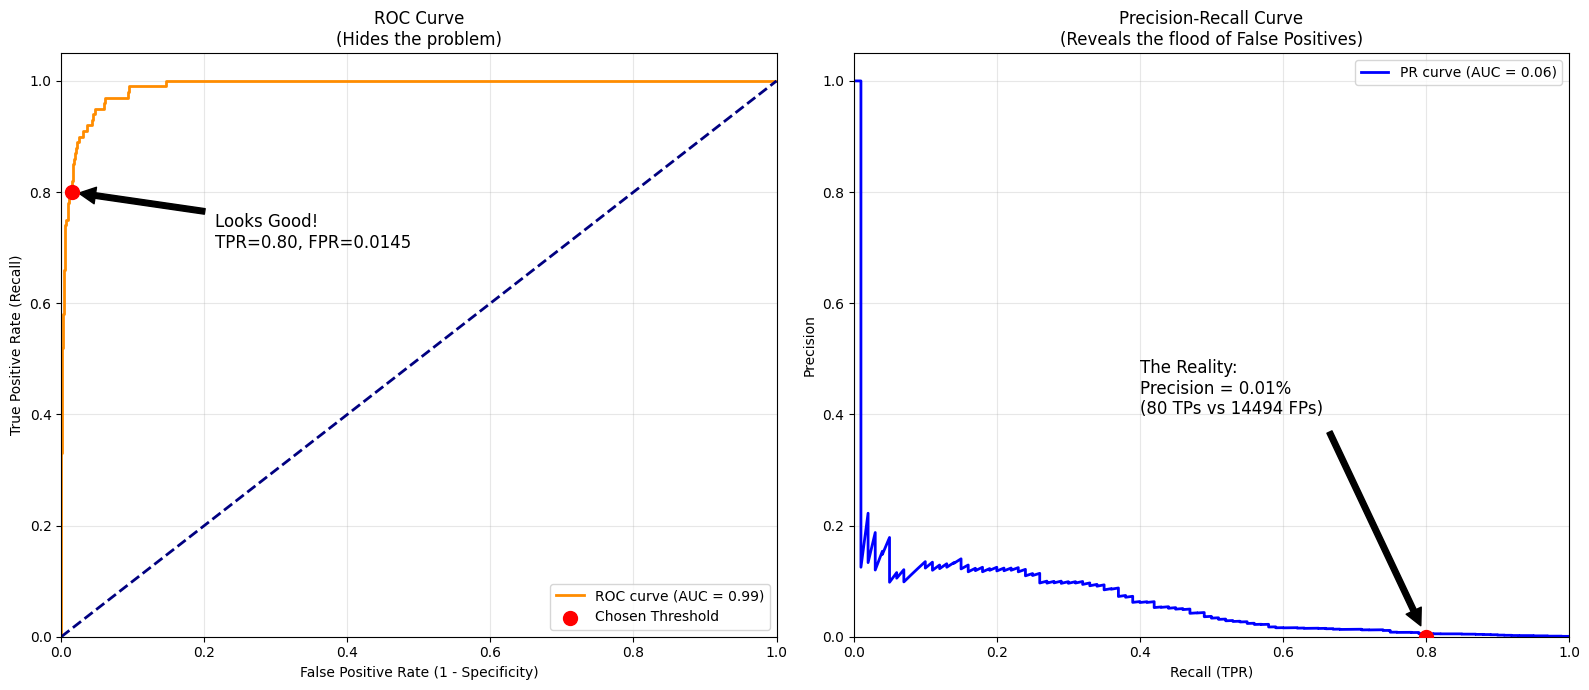

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# 1. Setup Extremely Low Prevalence Data (0.01%)
n_pos = 100    # Only 100 fraud cases
n_neg = 1000000 # 1 Million legit cases
# Prevalence = 0.01%

rng = np.random.default_rng(42)

# Model is "good" at separating:
# Positives centered at 1, Negatives centered at -1
# But with 1M negatives, the tail of the negative distribution will overlap significantly
scores_pos = rng.normal(loc=1.5, scale=1, size=n_pos)
scores_neg = rng.normal(loc=-1.5, scale=1, size=n_neg)

y_true = np.array([1] * n_pos + [0] * n_neg)
y_scores = np.concatenate([scores_pos, scores_neg])

# 2. Calculate Curves
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
precision, recall, _ = precision_recall_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# 3. Find a specific threshold to illustrate the "hiding"
# Let's pick a point where we catch 80% of fraudsters (Recall = 0.8)
target_tpr = 0.8
idx = np.argmin(np.abs(tpr - target_tpr))
chosen_fpr = fpr[idx]
chosen_tpr = tpr[idx]
chosen_precision = precision[idx]

# Calculate raw counts
fp_count = int(chosen_fpr * n_neg)
tp_count = int(chosen_tpr * n_pos)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ROC Plot - The "Illusion"
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.scatter([chosen_fpr], [chosen_tpr], color='red', s=100, zorder=5, label='Chosen Threshold')


# Annotation for ROC
ax1.annotate(f'Looks Good!\nTPR={chosen_tpr:.2f}, FPR={chosen_fpr:.4f}',
             (chosen_fpr, chosen_tpr),
             xytext=(chosen_fpr + 0.2, chosen_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve\n(Hides the problem)')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# PR Plot - The "Reality"
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.scatter([chosen_tpr], [chosen_precision], color='red', s=100, zorder=5)

# Annotation for PR
ax2.annotate(f'The Reality:\nPrecision = {chosen_precision:.2%}\n({tp_count} TPs vs {fp_count} FPs)',
             (chosen_tpr, chosen_precision),
             xytext=(chosen_tpr - 0.4, chosen_precision + 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall (TPR)')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve\n(Reveals the flood of False Positives)')
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('extreme_prevalence_roc_issue.png')

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Chosen Point -> TPR: {chosen_tpr:.2f}, FPR: {chosen_fpr:.5f}")
print(f"Real World Impact -> True Positives: {tp_count}, False Positives: {fp_count}")
print(f"Precision: {chosen_precision:.4f}")

```text
ROC AUC: 0.9899
Chosen Point -> TPR: 0.80, FPR: 0.01449
Real World Impact -> True Positives: 80, False Positives: 14494
Precision: 0.0001


```

To demonstrate this, I simulated an **extremely low prevalence** scenario (e.g., fraud detection or rare disease screening):

* **100** Positive cases (e.g., Fraud)
* **1,000,000** Negative cases (e.g., Legit transactions)
* Prevalence: **0.01%**

The plots below show the exact same model performance viewed through two different lenses.

### The Visual Illusion

1. **The ROC Curve (Left):** It looks fantastic. The curve hugs the top-left corner, and the AUC is **0.99**. A stakeholder looking at this would say, "This model is perfect!"
2. **The Precision-Recall Curve (Right):** It reveals a disaster. The curve hugs the bottom axis. The precision is practically zero.

### Why ROC "Hides" the Issue

Look at the red dot on the ROC curve.

* **FPR is 0.014 (1.4%)**: This looks "small" on the X-axis (0 to 1). It seems like a negligible error rate.
* **The Math Trick:** Because the denominator is **1,000,000**, a 1.4% error rate means **14,494 False Positives**.
* **The Reality:** You have caught **80** bad guys (True Positives), but you have falsely accused **14,494** innocent people.
* **The Ratio:** That is **181 false alarms for every 1 real catch**.

### Why This Matters

In extremely low prevalence settings, **the "empty space" on the left side of the ROC curve (FPR 0.0 to 0.1) actually contains the entire operational reality of your system.**

The ROC curve compresses the most critical information—the flood of false positives—into a tiny, invisible sliver on the x-axis, making a practically useless model (0.5% precision) look like a world-class classifier (0.99 AUC).